In [1]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import os
import glob

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from lmfit.models import Model, ConstantModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel

sns.set_context('talk')

In [2]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

# MCP detection efficiency vs. B-field set points (0.434 V = 0 G, 2.000 V = ~1.1 G)

In [3]:
POL_LIST = glob.glob('n37-Bfield_counting_efficiency-1.2G*.csv')
UNPOL_LIST = glob.glob('n37-Bfield_counting_efficiency-zero_field*.csv')

SET_NAME = '5s37s, 3S1 signal vs. B-field'
POL_NAME = '5s37s, 3S1 B=2.000 V'
UNPOL_NAME = '5s37s, 3S1 B=0.434 V'

ATOMIC = 1762.21810
ZEEMAN = 0
ORDER = 1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

## Retreive files and do some pre-processing

### Retrieve all the data files and put in to a single DataFrame

In [4]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

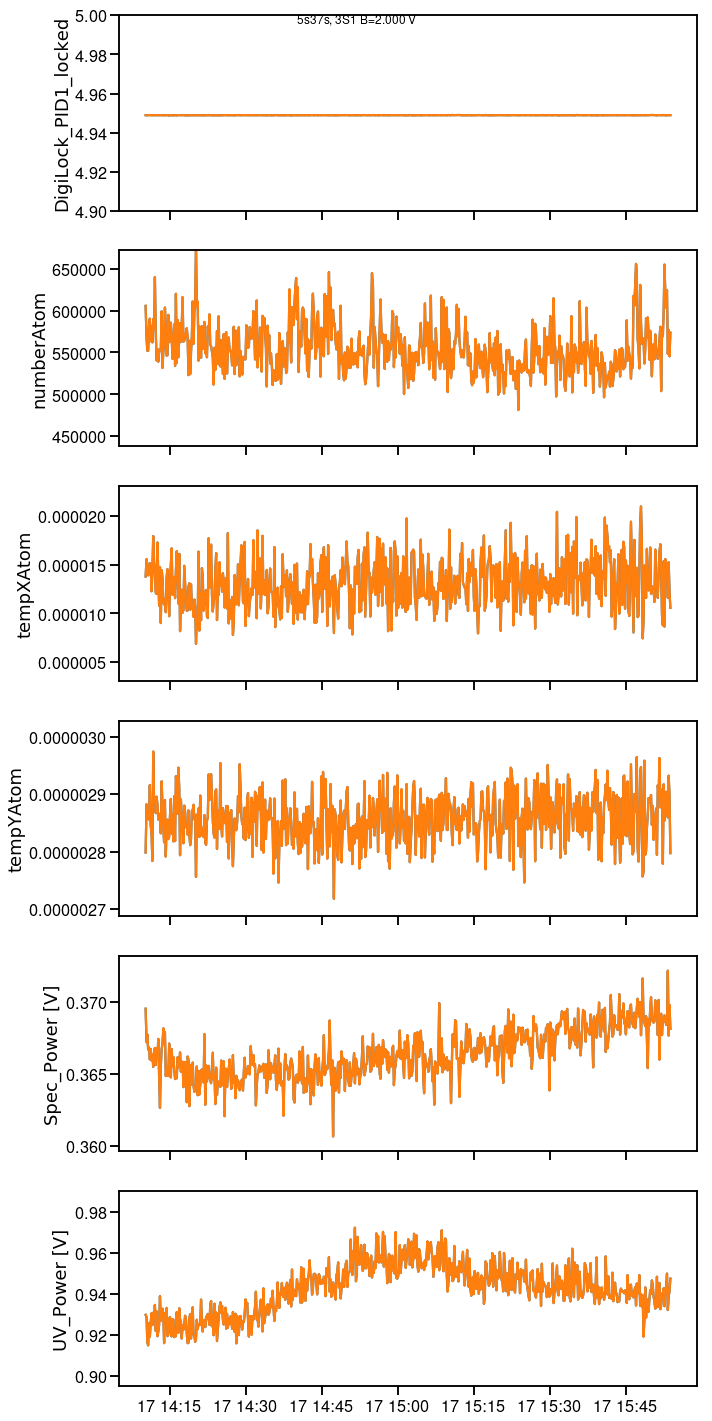

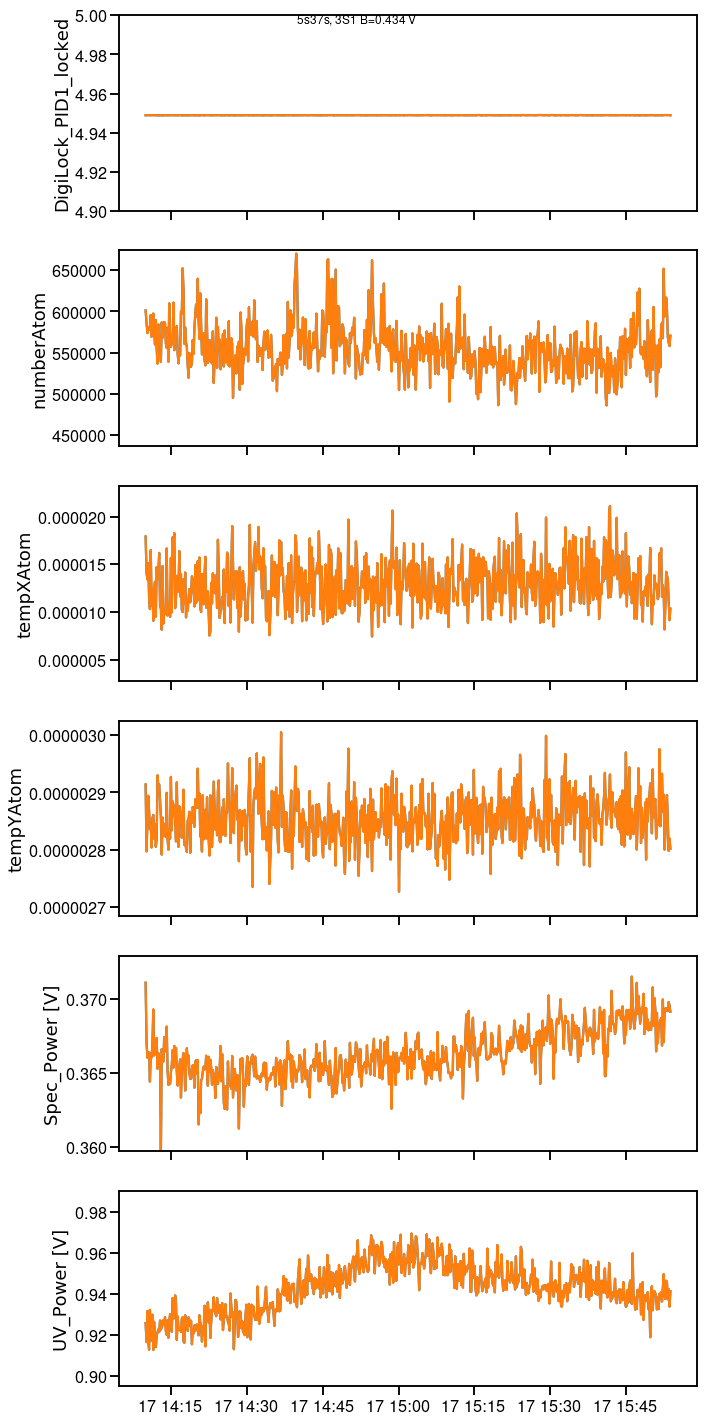

In [5]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where 640 nm wavemeter reading was more than 0.001 /cm from 15655.424 /cm (the location of the line)
    #df_reduced = df_reduced[(15655.423 <= df_reduced['wavemeterAtom']) & (df_reduced['wavemeterAtom'] <= 15655.425)]
    
    # Remove data where atom number was above/below cutoff
    #df_reduced = df_reduced[(300E3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 1E6)]
    
    # Remove data where tempYAtom was above/below cutoff
    #df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax] = plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name)

        ax[0].set_ylabel('DigiLock_PID1_locked', usetex=False)
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel('numberAtom', usetex=False)
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel('tempXAtom', usetex=False)
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel('tempYAtom', usetex=False)
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel('Spec_Power [V]', usetex=False)
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel('UV_Power [V]', usetex=False)
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

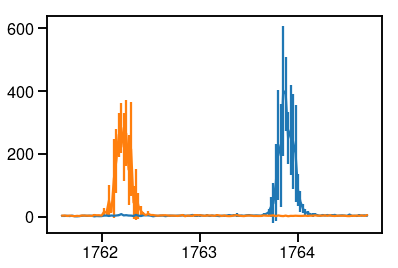

In [6]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std]})
    
    df_out['count'] = df_grouped.size().values
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

plt.errorbar(pol_out['imagevcoAtom'], pol_out['sfiIntegral','mean'], yerr=pol_out['sfiIntegral','std'])
plt.errorbar(unpol_out['imagevcoAtom'], unpol_out['sfiIntegral','mean'], yerr=unpol_out['sfiIntegral','std'])
plt.show()

### Adjust counts due to MCP saturation

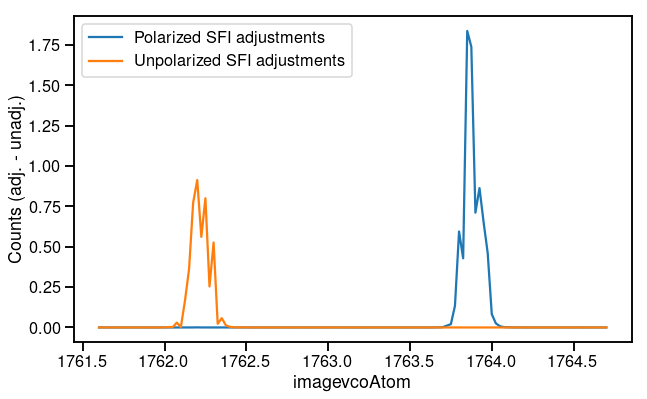

In [7]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

# Plot to check how much of a correction is applied to the MCP data
plt.figure(figsize=(10,6))

plt.plot(pol_out['imagevcoAtom'], pol_out['sfiIntegral_linearized','mean']-pol_out['sfiIntegral','mean'],
         label='Polarized SFI adjustments')
plt.plot(unpol_out['imagevcoAtom'], unpol_out['sfiIntegral_linearized','mean']-unpol_out['sfiIntegral','mean'],
         label='Unpolarized SFI adjustments')

#plt.gca().set_yscale('log')
plt.xlabel('imagevcoAtom')
plt.ylabel('Counts (adj. - unadj.)')
plt.legend()
plt.show()

In [8]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

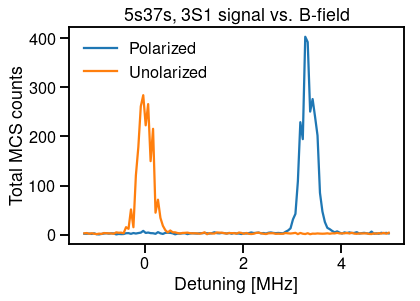

In [9]:
plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'], label='Polarized')
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'], label='Unolarized')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.legend(frameon=False)
plt.show()

## Processing the data for higher analysis

In [10]:
pol_data = pol_out
unpol_data = unpol_out

In [11]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

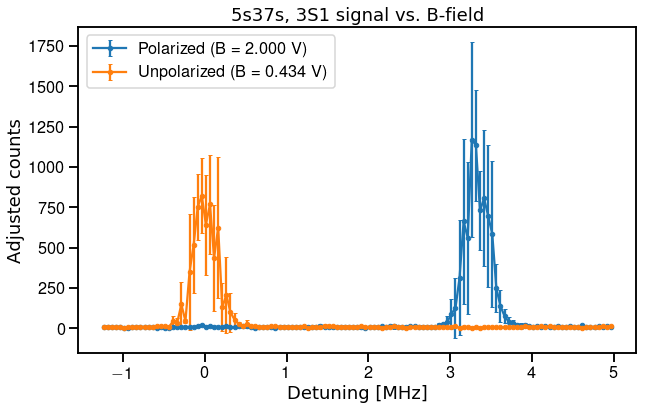

In [12]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized (B = 2.000 V)')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized (B = 0.434 V)')
#plt.gca().set_yscale('log')
plt.title(SET_NAME, usetex=False)
plt.xlabel('Detuning [MHz]', usetex=False)
plt.ylabel('Adjusted counts', usetex=False)
plt.legend()
plt.show()

# Analyzing the data - extracting detection efficiency

## B = 2.000 V ("polarized" data)

[[Model]]
    (Model(polynomial, prefix='bg_') + Model(gaussian, prefix='d0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 125
    # variables        = 4
    chi-square         = 223038.706
    reduced chi-square = 1843.29509
    Akaike info crit   = 943.848358
    Bayesian info crit = 955.161613
[[Variables]]
    bg_c0:         8.48093587 +/- 4.10160738 (48.36%) (init = 1.729973)
    d0_sigma:      0.14509193 +/- 0.00392223 (2.70%) (init = 3.344)
    d0_center:     3.32617218 +/- 0.00383339 (0.12%) (init = 3.32)
    d0_amplitude:  368.562965 +/- 9.00699040 (2.44%) (init = 269)
    d0_fwhm:       0.34166538 +/- 0.00923614 (2.70%) == '2.3548200*d0_sigma'
    d0_height:     1013.39445 +/- 23.3672476 (2.31%) == '0.3989423*d0_amplitude/max(1.e-15, d0_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(d0_sigma, d0_amplitude) =  0.603
    C(bg_c0, d0_amplitude)    = -0.351
    C(bg_c0, d0_sigma)        = -0.212



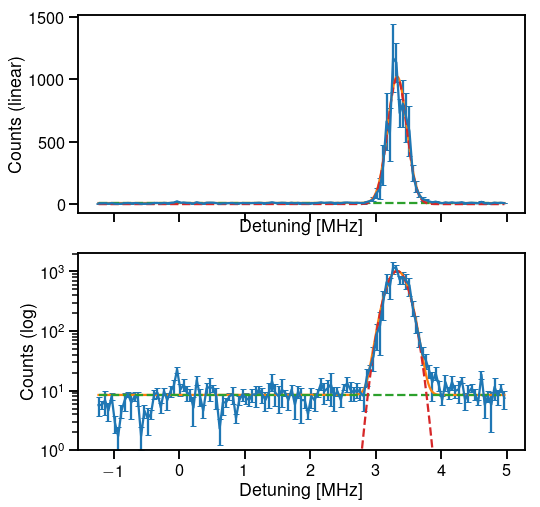

In [13]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = min(data['detuning'])
xmax = max(data['detuning'])

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']
counts = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['count']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = GaussianModel(prefix='d0_')

fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(3.32, vary=True)
fit_params['d0_amplitude'].set(269, min=0, vary=True)
fit_params['d0_sigma'].set(2*1.672, min=0, vary=True)

#fit_params['dx_center'].set(-19.5, vary=True)
#fit_params['dx_amplitude'].set(43, min=0, vary=True)
#fit_params['dx_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc/unumpy.sqrt(counts), capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc/unumpy.sqrt(counts), capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [14]:
# Saving to variables
pol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)

## B = 0.434 V ("unpolarized" data)

[[Model]]
    (Model(polynomial, prefix='bg_') + Model(gaussian, prefix='d0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 125
    # variables        = 4
    chi-square         = 151669.303
    reduced chi-square = 1253.46531
    Akaike info crit   = 895.643007
    Bayesian info crit = 906.956261
[[Variables]]
    bg_c0:         8.26048877 +/- 3.37721205 (40.88%) (init = 2.892591)
    d0_sigma:      0.14199254 +/- 0.00415081 (2.92%) (init = 3.42)
    d0_center:    -4.2450e-06 +/- 0.00405934 (95625.66%) (init = 0)
    d0_amplitude:  277.874221 +/- 7.33633586 (2.64%) (init = 347)
    d0_fwhm:       0.33436687 +/- 0.00977442 (2.92%) == '2.3548200*d0_sigma'
    d0_height:     780.715530 +/- 19.4740698 (2.49%) == '0.3989423*d0_amplitude/max(1.e-15, d0_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(d0_sigma, d0_amplitude) =  0.602
    C(bg_c0, d0_amplitude)    = -0.348
    C(bg_c0, d0_sigma)        = -0.209



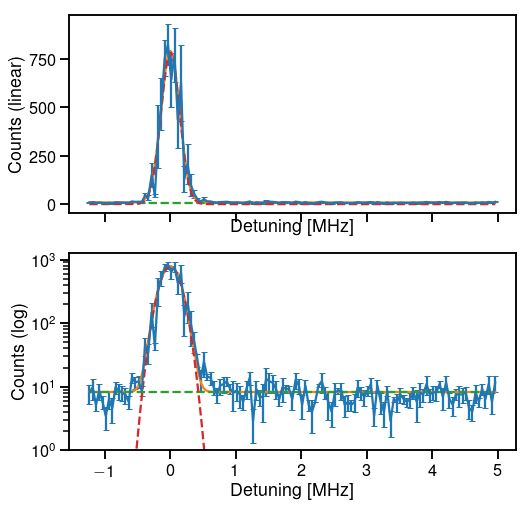

In [15]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = min(data['detuning'])
xmax = max(data['detuning'])

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = GaussianModel(prefix='d0_')

fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(0, vary=True)
fit_params['d0_amplitude'].set(347, min=0, vary=True)
fit_params['d0_sigma'].set(2*1.71, min=0, vary=True)

#fit_params['dx_center'].set(-19.5, vary=True)
#fit_params['dx_amplitude'].set(43, min=0, vary=True)
#fit_params['dx_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc/unumpy.sqrt(counts), capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc/unumpy.sqrt(counts), capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [16]:
# Saving to variables
unpol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)

## Ratio of the detection efficiencies

In [19]:
print(pol_int/unpol_int)

1.33+/-0.05
